In [1]:
import matplotlib
matplotlib.use('agg')
%matplotlib inline

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from os import path

In [3]:
print(tf.__version__)

1.3.0


In [5]:
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader
from tensorflow.contrib.timeseries.python.timeseries import estimators as ts_estimators
from tensorflow.contrib.timeseries.python.timeseries import model as ts_model

In [6]:
class _LSTMModel(ts_model.SequentialTimeSeriesModel):
    """ A time series model using RNNCell """
    
    def __init__(self, num_units, num_features, dtype=tf.float32):
        """Initialize/configure the model object.
        Note that we do not start graph building here. Rather, this object is a
        configurable factory for TensorFlow graphs which are run by an Estimator.
        Args:
          num_units: The number of units in the model's LSTMCell.
          num_features: The dimensionality of the time series (features per
            timestep).
          dtype: The floating point data type to use.
        """
        super(_LSTMModel, self).__init__(
            # Pre-register the metrics we'll be outputing (just a mean here).
            train_output_names=["mean"],
            predict_output_names=["mean"],
            num_features=num_features,
            dtype=dtype)
        self._num_units = num_units
        # Filled in by initialize_graph()
        self._lstm_cell = None
        self._lstm_cell_run = None
        self._predict_from_lstm_output = None
        
    def initialize_graph(self, input_statistics):
        """Save templates for components, which can then be used repeatedly.
        This method is called every time a new graph is created. It's safe to start
        adding ops to the current default graph here, but the graph should be
        constructed from scratch.
        Args:
          input_statistics: A math_utils.InputStatistics object.
        """
        super(_LSTMModel, self).initialize_graph(input_statistics=input_statistics)
        self._lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units=self._num_units)
        # create templates so we don't have to worry about variable reuse.
        self._lstm_cell_run = tf.make_template(name_="lstm_cell",
                                               func_=self._lstm_cell,
                                               create_scope_now_=True)
        
        # Transforms LSTM output into mean predictions.
        self._predict_from_lstm_output = tf.make_template(name_="predict_from_lstm_output",
                                                          func_=lambda inputs: tf.layers.dense(inputs=inputs,
                                                                                               units=self.num_features),
                                                          create_scope_now_=True)
        
    def get_start_state(self):
        """Return initial state for the time series model."""
        return (
            # Keeps track of the time associated with this state for error checking.
            tf.zeros([], dtype=tf.int64),
            # The previous observation or prediction
            tf.zeros([self.num_features], dtype=self.dtype),
            # the state of the RNNCell (batch dimention removed since this parent
            # class will brodcast).
            [tf.squeeze(state_element, axis=0)
                for state_element in self._lstm_cell.zero_state(batch_size=1, dtype=self.dtype)]
        )

    def _transform(self, data):
        """Normalize data based on input statistics to encourage stable training."""
        mean, variance = self._input_statistics.overall_feature_moments
        return (data - mean) / variance

    def _de_transform(self, data):
        """Transform data back to the input scale."""
        mean, variance = self._input_statistics.overall_feature_moments
        return data * variance + mean

    def _filtering_step(self, current_times, current_values, state, predictions):
        """Update model state based on observations.
        Note that we don't do much here aside from computing a loss. In this case
        it's easier to update the RNN state in _prediction_step, since that covers
        running the RNN both on observations (from this method) and our own
        predictions. This distinction can be important for probabilistic models,
        where repeatedly predicting without filtering should lead to low-confidence
        predictions.
        Args:
          current_times: A [batch size] integer Tensor.
          current_values: A [batch size, self.num_features] floating point Tensor
            with new observations.
          state: The model's state tuple.
          predictions: The output of the previous `_prediction_step`.
        Returns:
          A tuple of new state and a predictions dictionary updated to include a
          loss (note that we could also return other measures of goodness of fit,
          although only "loss" will be optimized).
        """  
        state_from_time, prediction, lstm_state = state
        with tf.control_dependencies([tf.assert_equal(current_times, state_from_time)]):
            transformed_values = self._transform(current_values)
            # use mean squared error across features for the loss.
            predictions["loss"] = tf.reduce_mean((prediction - transformed_values) ** 2, axis=-1)
            # keep track of the new observation in model state. It won't be run
            # through the LSTM until the next _imputation_step.
            new_state_tuple = (current_times, transformed_values, lstm_state)
        return (new_state_tuple, predictions)
    
    def _prediction_step(self, current_times, state):
        """Advance the RNN state using a previous observation or prediction."""
        _, previous_observation_or_prediction, lstm_state = state
        lstm_output, new_lstm_state = self._lstm_cell_run(inputs=previous_observation_or_prediction,
                                                          state=lstm_state)
        next_prediction = self._predict_from_lstm_output(lstm_output)
        new_prediction = self._predict_from_lstm_output(lstm_output)
        new_state_tuple = (current_times, next_prediction, new_lstm_state)
        return new_state_tuple, {"mean": self._de_transform(next_prediction)}
    
    def _imputation_step(self, current_times, state):
        """Advance model state across a gap."""
        # Does not do anything special if we're jumping across a gap. More advanced
        # models, especially probabilistic ones, would want a special case that
        # depends on the gap size.  
        return state
    
    def _gxogenous_input_step(self, current_times, current_exogenous_regressors, state):
        """Update model state based on exogenous regressors."""
        raise NotImplementedError("Exogenous inputs are not implemented for this example.")
        

In [7]:
tf.logging.set_verbosity(tf.logging.INFO)

In [11]:
csv_file_name = path.join("./data/multivariate_periods.csv")
reader = tf.contrib.timeseries.CSVReader(csv_file_name,
                                         column_names=((tf.contrib.timeseries.TrainEvalFeatures.TIMES,)
                                                       + (tf.contrib.timeseries.TrainEvalFeatures.VALUES,) * 5))

In [13]:
(tf.contrib.timeseries.TrainEvalFeatures.TIMES,) + (tf.contrib.timeseries.TrainEvalFeatures.VALUES,)

('times', 'values')

In [14]:
((tf.contrib.timeseries.TrainEvalFeatures.TIMES,) + (tf.contrib.timeseries.TrainEvalFeatures.VALUES,)) * 5

('times',
 'values',
 'times',
 'values',
 'times',
 'values',
 'times',
 'values',
 'times',
 'values')

In [16]:
train_input_fn = tf.contrib.timeseries.RandomWindowInputFn(reader,
                                                           batch_size=4,
                                                           window_size=32)
estimator = ts_estimators._TimeSeriesRegressor(model=_LSTMModel(num_features=5, num_units=128),
                                               optimizer=tf.train.AdamOptimizer(0.001))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\wuht\\AppData\\Local\\Temp\\tmpye2ltud3', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


In [17]:
estimator.train(input_fn=train_input_fn, steps=200)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\wuht\AppData\Local\Temp\tmpye2ltud3\model.ckpt.
INFO:tensorflow:loss = 1.97885, step = 1
INFO:tensorflow:global_step/sec: 50.8858
INFO:tensorflow:loss = 0.443867, step = 101 (1.981 sec)
INFO:tensorflow:Saving checkpoints for 200 into C:\Users\wuht\AppData\Local\Temp\tmpye2ltud3\model.ckpt.
INFO:tensorflow:Loss for final step: 0.153429.


In [22]:
evaluation_input_fn = tf.contrib.timeseries.WholeDatasetInputFn(reader)
evaluation = estimator.evaluate(input_fn=evaluation_input_fn, steps=1)

#predict starting after the evaluation
(predictions, ) = tuple(estimator.predict(
    input_fn=tf.contrib.timeseries.predict_continuation_input_fn(
        evaluation, steps=100)))

observed_times = evaluation["times"][0]
observed = evaluation["observed"][0, :, :]
evaluated_times = evaluation["times"][0]
evaluated = evaluation["mean"][0]
predicted_times = predictions['times']
predicted = predictions["mean"]

INFO:tensorflow:Starting evaluation at 2017-10-10-03:28:47
INFO:tensorflow:Restoring parameters from C:\Users\wuht\AppData\Local\Temp\tmpye2ltud3\model.ckpt-200
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-10-10-03:28:47
INFO:tensorflow:Saving dict for global step 200: global_step = 200, loss = 0.0975925, mean = [[[-0.03056068  1.19897342  2.50195265  3.73341441  5.01944923]
  [-0.69809002  1.53516567  2.5618906   3.59425473  4.7787056 ]
  [-0.87065345  1.37158024  2.42316365  3.42597771  4.58895731]
  [-0.17936054  1.1288147   2.23813105  3.29926419  4.43182373]
  [ 0.07599474  0.87301326  2.09281731  3.24021745  4.26333523]
  [-0.72104508  0.58664793  1.76746082  3.22412062  4.15809393]
  [-0.90947068  0.57699668  1.64481401  3.13506413  4.32490969]
  [ 0.03585706  0.8075307   1.62915349  3.14870954  4.46181631]
  [ 0.66155189  1.24979591  1.69415462  3.36439562  4.57564592]
  [-0.17435601  1.7231921   1.94600976  3.60463142  4.66176939]
  [-0.75234199

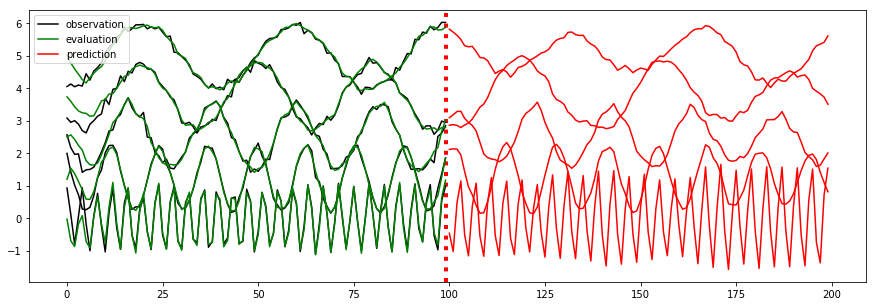

In [23]:
plt.figure(figsize=(15, 5))
plt.axvline(99, linestyle="dotted", linewidth=4, color='r')
observed_lines = plt.plot(observed_times, observed, label="observation", color="k")
evaluated_lines = plt.plot(evaluated_times, evaluated, label="evaluation", color="g")
predicted_lines = plt.plot(predicted_times, predicted, label="prediction", color="r")
plt.legend(handles=[observed_lines[0], evaluated_lines[0], predicted_lines[0]],
         loc="upper left")
plt.savefig('./img/predict_result.jpg')